# Preprocessing step

In [1]:
import pandas as pd
import numpy as np
from nltk.sentiment import SentimentIntensityAnalyzer

biden = pd.read_csv('/content/biden.csv')
metadata = pd.read_csv('/content/bidenYouTubeChannel2023.csv')

In [2]:
metadata_sorted = metadata.sort_values(by = 'ViewCount', ascending = False)

Drop columns that are not useful

In [3]:
metadata_sorted = metadata_sorted.drop(['Kind', 'ETag', 'ChannelId', 'DefaultThumbnailUrl','MediumThumbnailUrl','HighThumbnailUrl','StandardThumbnailUrl','MaxResThumbnailUrl' ], axis =1)

Insert the video topic. Topic are manually obtained by watching videos

In [4]:
metadata_sorted['Topic'] = ['campaign', 'social security', 'campaign','israel','campaign','economy','campaign','campaign','campaign','campaign','campaign','campaign','economy','roevwade','addressing','roevwade','campaign','ukraine','campaign','infrastructure','ukraine','campaign','campaign','union','addressing','women rights','campaign','campaign','senior healthcare','economy','campaign','education','addressing','environment','roevwade','economy','campaign','campaign','campaign','remarks','campaign','campaign','roevwade']

In [5]:
print(metadata_sorted['Topic'].unique())

['campaign' 'social security' 'israel' 'economy' 'roevwade' 'addressing'
 'ukraine' 'infrastructure' 'union' 'women rights' 'senior healthcare'
 'education' 'environment' 'remarks']


In [ ]:
print(metadata_sorted)

Merge the preprocessed data with the metadata

In [5]:
merged_biden = pd.merge(biden,metadata_sorted, on = 'Video ID', how = 'inner')

# Sentiment analysis using VADER

In [6]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

def rule_based_sentiment_analysis(text):
    sid = SentimentIntensityAnalyzer()
    sentiment_scores = sid.polarity_scores(text)

    # Determine sentiment based on compound score
    if sentiment_scores['compound'] >= 0.05:
        return 1
    elif sentiment_scores['compound'] > -0.05 and sentiment_scores['compound'] < 0.05:
        return 0
    else:
      return -1

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


This function will return all VADER scores

In [7]:
def rule_based_sentiment_analysis_scores(text):
    sid = SentimentIntensityAnalyzer()
    sentiment_scores = sid.polarity_scores(text)
    return sentiment_scores

In [8]:
X = []
for value in merged_biden['cleaned']:
  X.append(rule_based_sentiment_analysis(value))

In [9]:
Y = []
for value in merged_biden['cleaned']:
  Y.append(rule_based_sentiment_analysis_scores(value))

In [10]:
merged_biden['vader_label'] = X

In [11]:
new_data_df = pd.DataFrame(Y)


merged_biden = pd.concat([merged_biden, new_data_df], axis=1)

In [ ]:
print(merged_biden)

This code set the threshold for polarity

In [ ]:
merged_biden['polarity'] = np.where((merged_biden['vader_label'] == 1) & (merged_biden['pos'] > 0.5), 2,  # If vader_label is 1 and pos > 0.5, label 2
                              np.where((merged_biden['vader_label'] == 1) & (merged_biden['pos'] < 0.5), 1,  # If vader_label is 1 and pos < 0.5, label 1
                                       np.where((merged_biden['vader_label'] == -1) & (merged_biden['neg'] < -0.5), -2,  # If vader_label is -1 and neg < -0.5, label -2
                                                np.where((merged_biden['vader_label'] == -1) & (merged_biden['neg'] > -0.5), -1,  # If vader_label is -1 and neg > -0.5, label -1
                                                         np.where(merged_biden['vader_label'] == 0, 0,-1)))))  # If vader_label is 0, label 0, otherwise -1


print(merged_biden)

In [ ]:
polarity_counts = merged_biden.groupby(['Topic', 'polarity']).size().reset_index(name='count')
print(polarity_counts)

In [14]:
count_trump_senti = merged_biden.groupby('Topic')['vader_label'].value_counts().unstack(fill_value=0).sort_values(by=1)

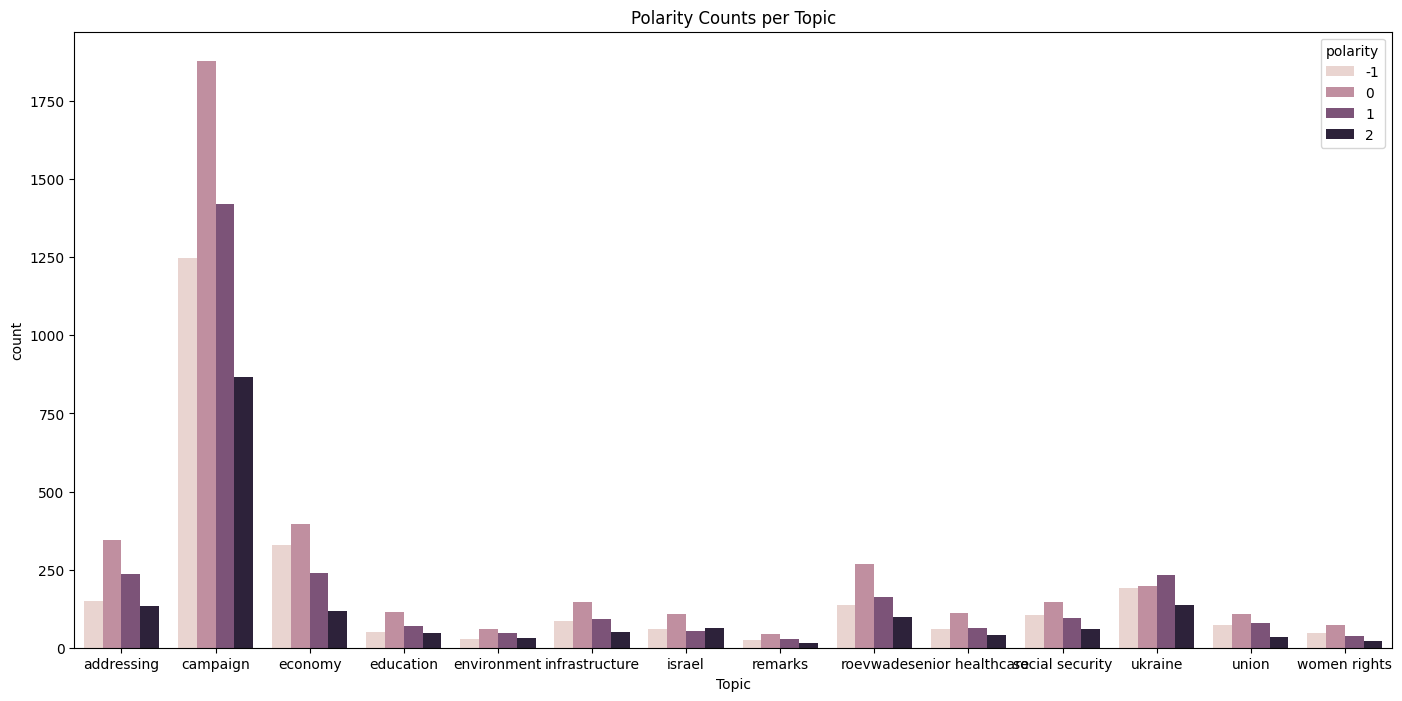

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(17, 8))
# Assuming polarity_counts DataFrame from the previous code snippet
sns.barplot(x='Topic', y='count', hue='polarity', data=polarity_counts)
plt.title('Polarity Counts per Topic')
plt.show()

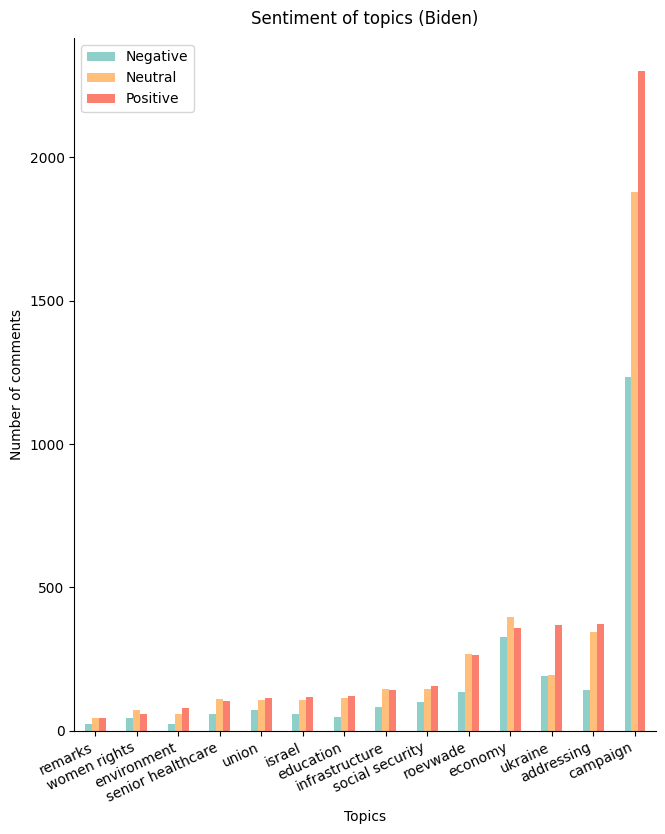

In [16]:

colors = ['#8ECFC9', '#FFBE7A', '#FA7F6F', '#82B0D2', '#BEB8DC', '#E7DAD2']
fig, ax = plt.subplots(figsize=(7.5, 9))
count_trump_senti.plot(kind='bar', color=colors, ax=ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Topics")
ax.set_ylabel("Number of comments")
ax.set_title("Sentiment of topics (Biden)", pad=10)
ax.legend(['Negative', 'Neutral', 'Positive'])
plt.xticks(rotation=25, ha='right')
plt.savefig('senti_topics_biden.png')

In [17]:
merged_biden['date'] = pd.to_datetime(merged_biden['Comment Published At'], format='%Y-%m-%dT%H:%M:%SZ').dt.strftime('%Y-%m-%d')

# Now 'date' column contains the date in the 'YYYY-MM-DD' format
print(merged_biden['date'])

0        2023-07-19
1        2023-07-19
2        2023-07-19
3        2023-07-19
4        2023-07-20
            ...    
11144    2023-06-23
11145    2023-07-12
11146    2023-06-24
11147    2023-06-24
11148    2023-06-29
Name: date, Length: 11149, dtype: object


In [18]:
merged_biden['date'] = pd.to_datetime(merged_biden['date'])

In [19]:
label_counts_per_month = merged_biden.groupby([merged_biden['date'].dt.to_period('M'), 'vader_label']).size().unstack(fill_value=0)

# Now 'label_counts_per_month' is a DataFrame containing the counts of each label per month
print(label_counts_per_month)

vader_label   -1    0    1
date                      
2023-02       23   40   46
2023-03       36   90  115
2023-04      182  277  338
2023-05      286  447  512
2023-06      164  303  357
2023-07      306  488  596
2023-08      423  749  812
2023-09      531  663  706
2023-10      314  412  458
2023-11      126  213  266
2023-12      152  289  371
2024-01        7   22   29


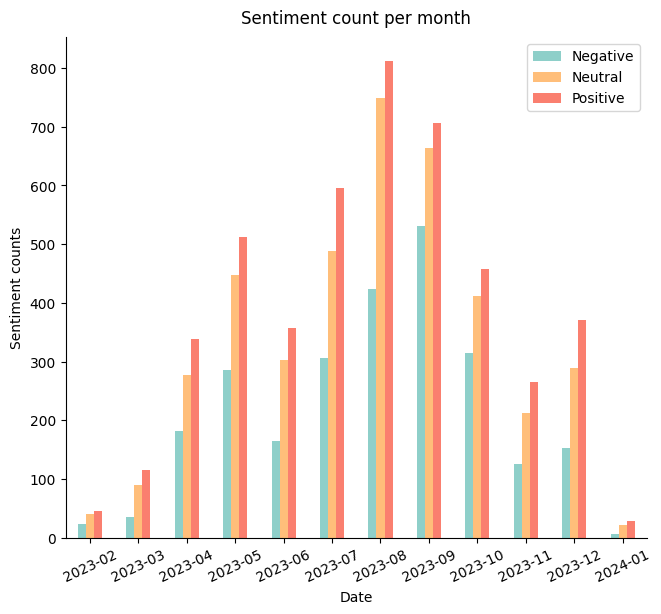

In [20]:
colors = ['#8ECFC9', '#FFBE7A', '#FA7F6F', '#82B0D2', '#BEB8DC', '#E7DAD2']
fig, ax = plt.subplots(figsize=(7.5, 6.5))
label_counts_per_month.plot(kind='bar', ax=ax, color= colors)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Date")
ax.set_ylabel("Sentiment counts")
ax.set_title("Sentiment count per month", pad=10)
ax.legend(['Negative','Neutral','Positive'])
plt.xticks(rotation=25)

plt.savefig('Sentiment count per month (biden).png')

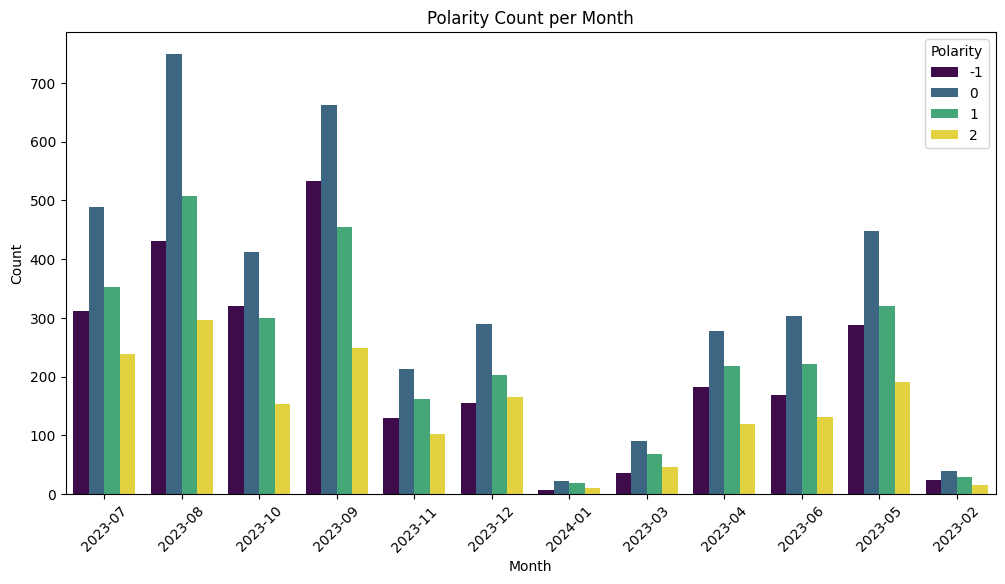

In [21]:
plt.figure(figsize=(12, 6))
sns.countplot(x= merged_biden['date'].dt.to_period('M').sort_values(), hue='polarity', data=merged_biden, palette='viridis')
plt.title('Polarity Count per Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Polarity', loc='upper right')
plt.show()